<a href="https://colab.research.google.com/github/nasirxia/Analysis-Project-2022-Fall/blob/main/AmazonFashion_ALP_qnyue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Amazon Fashion Persona @qnyue

 0. Import libraries 

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 5
pd.set_option('display.max_columns', 100)
import io
import requests
import warnings
import csv
np.random.seed(27)
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats

In [2]:
##Check your working directory
os.getcwd()

'/content'

A couple of ways reading the data: 1) from S3 2) from cluster 3) upload csv and read it here

In [5]:
df = pd.read_csv('/content/sample_data/Data0131.csv', encoding="ISO-8859-1")
df.head()

,ï»¿sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,sales,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime
0,1,2022-01-01,Sponsored Products,224143037,Seattle Gourmet,Seattle Gourmet Adult 7+ Small Bites Chicken M...,16.14,2,32.28,1223,M,Shreveport,LA,71130,32.6076,-93.7526,Single,College graduate,"$60,000 - $79,999",55-64,1
1,2,2022-01-01,Don't recall seeing an ad,834182030,Garland Farms,Garland Farms Healthy Grains Dry Dog Food with...,21.83,3,65.49,2946,M,Fresno,CA,93794,36.7464,-119.6397,Single,High school graduate,"$60,000 - $79,999",35-44,1
2,3,2022-01-01,Don't recall seeing an ad,950844039,Doggo,"Doggo Kibble Dry Dog Food, 20 lb, with Plant B...",57.99,3,173.97,4448,M,Danbury,CT,6816,41.3089,-73.3637,Single,College graduate,"Less than $20,000",25-34,1
3,4,2022-01-01,Sponsored Products,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",63.98,2,127.96,4510,F,San Antonio,TX,78215,29.4413,-98.4793,Married,College graduate,"$20,000 - $39,999",25-34,1
4,5,2022-01-01,Don't recall seeing an ad,151595003,Alpha,"Alpha Natural Sensitive Systems, Skin & Coat S...",48.99,1,48.99,370,F,Boise,ID,83711,43.4599,-116.2440,Married,Some college or trade school,"$80,000 - $99,999",55-64,0


2. Create additional variables

In [6]:
#additional varaibles
df['ad_exp'].value_counts()

Don't recall seeing an ad    3096
Sponsored Brands             2520
Sponsored Products           2017
Display/banner ad            1297
Video ad                      254
Some other type of ad          31
Name: ad_exp, dtype: int64

In [7]:
df['ad_ind']= np.where(df['ad_exp']=="Don't recall seeing an ad", 0,1)
df['ad_ind'].value_counts()

1    6119
0    3096
Name: ad_ind, dtype: int64

In [8]:
df['marital'].value_counts()

Married                                  4706
Single                                   3663
Domestic partner/serious relationship     846
Name: marital, dtype: int64

In [9]:
df['ma_ind']= np.where(df['marital']=="Single", 0,1)
df['ma_ind'].value_counts()

1    5552
0    3663
Name: ma_ind, dtype: int64

In [10]:
df['education'].value_counts()

College graduate                4101
Some college or trade school    1946
High school graduate            1745
Post graduate                   1423
Name: education, dtype: int64

In [11]:
df['edu_ind']= np.where(df['education']=="High school graduate", 0, np.where(df['education']=="Some college or trade school", 0,1))
df['edu_ind'].value_counts()


1    5524
0    3691
Name: edu_ind, dtype: int64

In [12]:
df['income'].value_counts()

$100,000 or more     2754
$80,000 - $99,999    1537
$60,000 - $79,999    1469
$40,000 - $59,999    1442
$20,000 - $39,999    1426
Less than $20,000     587
Name: income, dtype: int64

In [13]:
def level(row): 
    if row['income'] == "Less than $20,000": 
        return '0'
    elif row['income'] == "$20,000 - $39,999":
        return '1'
    elif row['income'] == "$40,000 - $59,999":
        return '2'
    elif row['income'] == "$60,000 - $79,999":
        return '3'    
    elif row['income'] == "$80,000 - $99,999":
        return '4'  
    elif row['income'] == "$100,000 or more":
        return '5'  
    return 'other' 

In [14]:
df['income_level'] = df.apply(level, axis=1)

In [20]:
df['income_level'].value_counts() 

5    2754
4    1537
3    1469
2    1442
1    1426
0     587
Name: income_level, dtype: int64

In [17]:
df.head()

,ï»¿sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,sales,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime,ad_ind,ma_ind,edu_ind,income_level
0,1,2022-01-01,Sponsored Products,224143037,Seattle Gourmet,Seattle Gourmet Adult 7+ Small Bites Chicken M...,16.14,2,32.28,1223,M,Shreveport,LA,71130,32.6076,-93.7526,Single,College graduate,"$60,000 - $79,999",55-64,1,1,0,1,3
1,2,2022-01-01,Don't recall seeing an ad,834182030,Garland Farms,Garland Farms Healthy Grains Dry Dog Food with...,21.83,3,65.49,2946,M,Fresno,CA,93794,36.7464,-119.6397,Single,High school graduate,"$60,000 - $79,999",35-44,1,0,0,0,3
2,3,2022-01-01,Don't recall seeing an ad,950844039,Doggo,"Doggo Kibble Dry Dog Food, 20 lb, with Plant B...",57.99,3,173.97,4448,M,Danbury,CT,6816,41.3089,-73.3637,Single,College graduate,"Less than $20,000",25-34,1,0,0,1,0
3,4,2022-01-01,Sponsored Products,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",63.98,2,127.96,4510,F,San Antonio,TX,78215,29.4413,-98.4793,Married,College graduate,"$20,000 - $39,999",25-34,1,1,1,1,1
4,5,2022-01-01,Don't recall seeing an ad,151595003,Alpha,"Alpha Natural Sensitive Systems, Skin & Coat S...",48.99,1,48.99,370,F,Boise,ID,83711,43.4599,-116.2440,Married,Some college or trade school,"$80,000 - $99,999",55-64,0,0,1,0,4


In [18]:
df.columns

Index(['ï»¿sale_id', 'sale_date', 'ad_exp', 'product_id', 'product_brand',
       'product_name', 'price', 'qty', 'sales', 'customer_id', 'gender',
       'city', 'st', 'zip', 'lat', 'lng', 'marital', 'education', 'income',
       'age', 'prime', 'ad_ind', 'ma_ind', 'edu_ind', 'income_level'],
      dtype='object')

In [19]:
df.dtypes

ï»¿sale_id         int64
sale_date         object
ad_exp            object
product_id         int64
product_brand     object
product_name      object
price            float64
qty                int64
sales            float64
customer_id        int64
gender            object
city              object
st                object
zip                int64
lat              float64
lng              float64
marital           object
education         object
income            object
age               object
prime              int64
ad_ind             int64
ma_ind             int64
edu_ind            int64
income_level      object
dtype: object

In [22]:
df['income_level'] = df['income_level'].astype(int)


In [24]:
df['product_count'] = (
    df.groupby(['customer_id'])['product_name'].transform('nunique')) # how many products the consutomer bought

In [27]:
df

,ï»¿sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,sales,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime,ad_ind,ma_ind,edu_ind,income_level,product_count
0,1,2022-01-01,Sponsored Products,224143037,Seattle Gourmet,Seattle Gourmet Adult 7+ Small Bites Chicken M...,16.14,2,32.28,1223,M,Shreveport,LA,71130,32.6076,-93.7526,Single,College graduate,"$60,000 - $79,999",55-64,1,1,0,1,3,1
1,2,2022-01-01,Don't recall seeing an ad,834182030,Garland Farms,Garland Farms Healthy Grains Dry Dog Food with...,21.83,3,65.49,2946,M,Fresno,CA,93794,36.7464,-119.6397,Single,High school graduate,"$60,000 - $79,999",35-44,1,0,0,0,3,1
2,3,2022-01-01,Don't recall seeing an ad,950844039,Doggo,"Doggo Kibble Dry Dog Food, 20 lb, with Plant B...",57.99,3,173.97,4448,M,Danbury,CT,6816,41.3089,-73.3637,Single,College graduate,"Less than $20,000",25-34,1,0,0,1,0,1
3,4,2022-01-01,Sponsored Products,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",63.98,2,127.96,4510,F,San Antonio,TX,78215,29.4413,-98.4793,Married,College graduate,"$20,000 - $39,999",25-34,1,1,1,1,1,1
4,5,2022-01-01,Don't recall seeing an ad,151595003,Alpha,"Alpha Natural Sensitive Systems, Skin & Coat S...",48.99,1,48.99,370,F,Boise,ID,83711,43.4599,-116.2440,Married,Some college or trade school,"$80,000 - $99,999",55-64,0,0,1,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210,9211,2022-12-31,Don't recall seeing an ad,644028013,Health One,Health One NATURAL CHOICE Natural Adult Dry Do...,59.83,1,59.83,1975,F,Detroit,MI,48232,42.2399,-83.1508,Married,High school graduate,"$20,000 - $39,999",35-44,1,0,1,0,1,2
9211,9212,2022-12-31,Don't recall seeing an ad,123910010,Bezt,Bezt Natural Adult Healthy Weight Chicken and ...,54.14,1,54.14,2175,M,Flint,MI,48550,43.0349,-83.6887,Married,Some college or trade school,"$100,000 or more",35-44,1,0,1,0,5,3
9212,9213,2022-12-31,Don't recall seeing an ad,810662032,Arf,Arf Wholesome Grains Dry Dog Food (Chicken/Sal...,51.96,1,51.96,2724,F,Rochester,MN,55905,44.0225,-92.4668,Single,Some college or trade school,"$40,000 - $59,999",55-64,0,0,0,0,2,3
9213,9214,2022-12-31,Display/banner ad,208949071,Beam,"Beam Premium Natural Dry Dog Food, Real Chicke...",37.98,1,37.98,2766,M,Southfield,MI,48076,42.4981,-83.2058,Single,College graduate,"$20,000 - $39,999",45-54,0,1,0,1,1,1


In [28]:
df['brand_count'] = (
    df.groupby(['customer_id'])['product_brand'].transform('nunique'))

In [29]:
df.head()

,ï»¿sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,sales,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime,ad_ind,ma_ind,edu_ind,income_level,product_count,brand_count
0,1,2022-01-01,Sponsored Products,224143037,Seattle Gourmet,Seattle Gourmet Adult 7+ Small Bites Chicken M...,16.14,2,32.28,1223,M,Shreveport,LA,71130,32.6076,-93.7526,Single,College graduate,"$60,000 - $79,999",55-64,1,1,0,1,3,1,1
1,2,2022-01-01,Don't recall seeing an ad,834182030,Garland Farms,Garland Farms Healthy Grains Dry Dog Food with...,21.83,3,65.49,2946,M,Fresno,CA,93794,36.7464,-119.6397,Single,High school graduate,"$60,000 - $79,999",35-44,1,0,0,0,3,1,1
2,3,2022-01-01,Don't recall seeing an ad,950844039,Doggo,"Doggo Kibble Dry Dog Food, 20 lb, with Plant B...",57.99,3,173.97,4448,M,Danbury,CT,6816,41.3089,-73.3637,Single,College graduate,"Less than $20,000",25-34,1,0,0,1,0,1,1
3,4,2022-01-01,Sponsored Products,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",63.98,2,127.96,4510,F,San Antonio,TX,78215,29.4413,-98.4793,Married,College graduate,"$20,000 - $39,999",25-34,1,1,1,1,1,1,1
4,5,2022-01-01,Don't recall seeing an ad,151595003,Alpha,"Alpha Natural Sensitive Systems, Skin & Coat S...",48.99,1,48.99,370,F,Boise,ID,83711,43.4599,-116.2440,Married,Some college or trade school,"$80,000 - $99,999",55-64,0,0,1,0,4,2,2


In [31]:
df2=df.groupby('customer_id').agg({'ad_ind':'mean','prime':'mean','ma_ind':'mean','edu_ind':'mean','income_level':'mean','product_count':'mean','brand_count':'mean' })
df2

,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count
customer_id,,,,,,,
1,1.00,1.0,0.0,1.0,1.0,1.0,1.0
2,1.00,1.0,1.0,1.0,1.0,1.0,1.0
3,0.75,0.0,0.0,1.0,5.0,4.0,4.0
4,1.00,1.0,0.0,0.0,1.0,3.0,3.0
5,0.00,1.0,0.0,0.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...
4996,0.00,1.0,0.0,0.0,3.0,1.0,1.0
4997,1.00,1.0,1.0,0.0,4.0,1.0,1.0
4998,0.50,1.0,1.0,0.0,4.0,2.0,2.0


In [34]:
df2.reset_index(inplace=True)


In [35]:
df2.head()

,index,customer_id,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count
0,0,1,1.00,1.0,0.0,1.0,1.0,1.0,1.0
1,1,2,1.00,1.0,1.0,1.0,1.0,1.0,1.0
2,2,3,0.75,0.0,0.0,1.0,5.0,4.0,4.0
3,3,4,1.00,1.0,0.0,0.0,1.0,3.0,3.0
4,4,5,0.00,1.0,0.0,0.0,2.0,1.0,1.0


In [ ]:
data = df2.drop(columns = 'customer_id')
ss = StandardScaler()
data = ss.fit_transform(data)

In [ ]:
df2.set_index('customer_id', inplace=True)

6. Run Cluster Analysis 

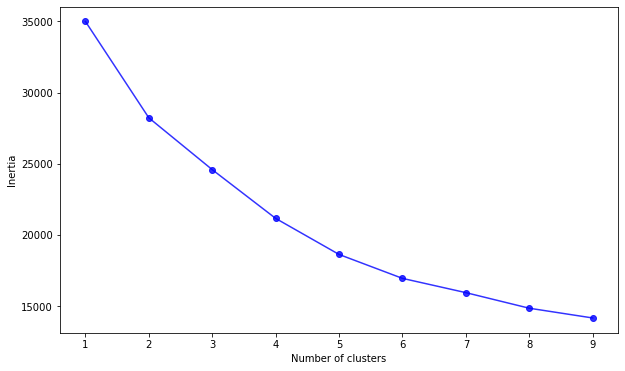

In [ ]:
##inertia is calculated as the sum of squared distance for each point to it's closest centroid

ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters = k)
    
    model.fit(data)
    inertias.append(model.inertia_)
    
plt.figure(figsize = (10,6))    
plt.plot(ks, inertias, '-o', color = 'blue', alpha = 0.8)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(data)

KMeans(n_clusters=2)

In [ ]:
df_cluster_labels = pd.DataFrame(kmeans.labels_, index = df2.index, columns = ['cluster_label']).reset_index()

##### a couple of additional metrics to evaluate cluster but it could take a while. So skip if you prefer. 

In [ ]:
df2.head()

,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count
customer_id,,,,,,,
1,1.00,1,0,1,1,1,1
2,1.00,1,1,1,1,1,1
3,0.75,0,0,1,5,4,4
4,1.00,1,0,0,1,3,3
5,0.00,1,0,0,2,1,1


In [ ]:
df_cluster_labels.head()

,customer_id,cluster_label
0,1,0
1,2,0
2,3,1
3,4,1
4,5,0


In [ ]:
df_cluster = df2.merge(df_cluster_labels, how = 'left', left_on = 'customer_id', right_on = 'customer_id')

df_cluster.head(5)

,customer_id,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count,cluster_label
0,1,1.00,1,0,1,1,1,1,0
1,2,1.00,1,1,1,1,1,1,0
2,3,0.75,0,0,1,5,4,4,1
3,4,1.00,1,0,0,1,3,3,1
4,5,0.00,1,0,0,2,1,1,0


In [ ]:
df_cluster.groupby('cluster_label').describe()

customer_id                                                 \
                    count         mean          std  min     25%     50%   
cluster_label                                                              
0                  2719.0  2509.674145  1447.258474  1.0  1248.0  2518.0   
1                  2281.0  2489.564226  1439.291743  3.0  1261.0  2486.0   

                               ad_ind                                          \
                  75%     max   count      mean       std  min  25%       50%   
cluster_label                                                                   
0              3772.0  5000.0  2719.0  0.664276  0.460259  0.0  0.0  1.000000   
1              3722.0  4998.0  2281.0  0.664910  0.315390  0.0  0.5  0.666667   

                          prime                                               \
               75%  max   count      mean       std  min  25%  50%  75%  max   
cluster_label                                                                  
0              1.0  1.0  2719.0  0.848841  0.358269  0.0  1.0  1.0  1.0  1.0   
1              1.0  1.0  2281.0  0.856203  0.350960  0.0  1.0  1.0  1.0  1.0   

               ma_ind                                              edu_ind  \
                count      mean       std  min  25%  50%  75%  max   count   
cluster_label                                                                
0              2719.0  0.607944  0.488299  0.0  0.0  1.0  1.0  1.0  2719.0   
1              2281.0  0.597983  0.490413  0.0  0.0  1.0  1.0  1.0  2281.0   

                                                           income_level  \
                   mean       std  min  25%  50%  75%  max        count   
cluster_label                                                             
0              0.606473  0.488622  0.0  0.0  1.0  1.0  1.0       2719.0   
1              0.598422  0.490325  0.0  0.0  1.0  1.0  1.0       2281.0   

                                                           product_count  \
                   mean       std  min  25%  50%  75%  max         count   
cluster_label                                                              
0              3.101876  1.634657  0.0  2.0  3.0  5.0  5.0        2719.0   
1              3.117054  1.660922  0.0  2.0  3.0  5.0  5.0        2281.0   

                                                           brand_count  \
                   mean       std  min  25%  50%  75%  max       count   
cluster_label                                                            
0              1.088636  0.284269  1.0  1.0  1.0  1.0  2.0      2719.0   
1              2.493205  0.739886  2.0  2.0  2.0  3.0  7.0      2281.0   

                                                           
                   mean      std  min  25%  50%  75%  max  
cluster_label                                              
0              1.000000  0.00000  1.0  1.0  1.0  1.0  1.0  
1              2.320473  0.59336  1.0  2.0  2.0  3.0  5.0